### Data Layout
 - API response that describes the dataset contents:


In [ ]:
import requests
import json

collectionId = 189
url = "https://api-production.data.gov.sg/v2/public/api/collections/{}/metadata".format(collectionId)
response = requests.get(url)

# Sample JSON data
data = response.json()

# Convert the data to a JSON formatted string with 4 spaces of indentation
json_str = json.dumps(data, indent=4)

# Print the pretty-printed JSON string
print(json_str)


{
    "code": 0,
    "data": {
        "collectionMetadata": {
            "collectionId": "189",
            "createdAt": "2015-09-22T15:05:30+08:00",
            "name": "Resale Flat Prices",
            "description": "Resale transacted prices. \r\nPrior to March 2012, data is based on date of approval for the resale transactions.  \r\nFor March 2012 onwards, the data is based on date of registration for the resale transactions.",
            "lastUpdatedAt": "2024-09-20T08:50:16+08:00",
            "coverageStart": "1990-01-01T08:00:00+08:00",
            "coverageEnd": "2024-04-08T00:00:00+08:00",
            "frequency": "monthly",
            "sources": [
                "Housing and Development Board"
            ],
            "managedBy": "Housing and Development Board",
            "childDatasets": [
                "d_8b84c4ee58e3cfc0ece0d773c8ca6abc",
                "d_43f493c6c50d54243cc1eab0df142d6a",
                "d_2d5ff9ea31397b66239f245f57751537",
               

### Basic characteristics of the Dataset:
  - Load Dataset from CSV into DataFrames
  - Aggregate all DFs into one (df)


In [ ]:
import pandas as pd
import numpy as np
'''
  Load the Singapore Housing Project dataset
'''
df_1999=pd.read_csv('SH_19901999.csv')
df_2012=pd.read_csv('SH_Jan2000Feb2012.csv')
df_2014=pd.read_csv('SH_Mar2012toDec2014.csv')
df_2016=pd.read_csv('SH_Jan2015toDec2016.csv')
df_present=pd.read_csv('SH_Jan2017onwards.csv')

df_2016=df_2016.drop(columns=['remaining_lease'])
df_present=df_present.drop(columns=['remaining_lease'])

df = pd.concat([df_1999, df_2012, df_2014, df_2016, df_present]).reset_index().drop(columns=['index'])

print(f'''Overview:
  1. Dataset shape: 1990-99: {df_1999.shape}, 2000-2012: {df_2012.shape}, 2012-2014: {df_2014.shape}, 2015-2016:{df_2016.shape}, 2017-Present:{df_present.shape}
  2. Columns present in datasets upto 2014: {df_1999.columns.to_list()}
  3. 'remaining_lease' column present in datasets from 2015 onwards is being dropped because lease term already captures and age factor
  4. Shape of aggregated dataframe: {df.shape}
  5. Columns data types:
{df_present.dtypes.to_markdown()}
  ''')
print("\n")


Overview:
  1. Dataset shape: 1990-99: (287196, 10), 2000-2012: (369651, 10), 2012-2014: (52203, 10), 2015-2016:(37153, 10), 2017-Present:(188515, 10)
  2. Columns present in datasets upto 2014: ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']
  3. 'remaining_lease' column present in datasets from 2015 onwards is being dropped because lease term already captures and age factor
  4. Shape of aggregated dataframe: (934718, 10)
  5. Columns data types:
|                     | 0       |
|:--------------------|:--------|
| month               | object  |
| town                | object  |
| flat_type           | object  |
| block               | object  |
| street_name         | object  |
| storey_range        | object  |
| floor_area_sqm      | float64 |
| flat_model          | object  |
| lease_commence_date | int64   |
| resale_price        | float64 |
  




### Data Preprocessing: Organize month,year, town, block columns
- Parse the 'month-year' into 'year' column. Add the year after multiplying by 10 and month to make it a chronological number.
- Add a new column 'localion' from town+block columns
- Compute 'mean_storey' column which is the mean of Start and End from  'storey_range' data
- Modify column data types for further computation
- Check for missing values & duplicates

In [ ]:

# 'location' column to replace 'town' and 'block'
df['location'] = df['town'] + '_' + df['block']

# Compute average from start+end floor in 'storey_range' to create 'mean_storey' column
df['mean_storey']=df['storey_range'].apply(lambda x: (int(x.split('TO')[0]) + int(x.split('TO')[1])))/2

df = df.convert_dtypes()
dup_df = df.duplicated()
df.drop_duplicates(inplace=True)

# Capture 'year' instead of 'year+month' in the 'year' column
df['year'] = df['month'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['month'].apply(lambda x: int(x.split('-')[1]))
df['year'] = df['year']*10 + df ['month']

# Drop unwanted columns
df.drop(columns=['town', 'block', 'street_name', 'storey_range', 'month'], inplace=True)
print(f'''
1. Any column having empty values: {df.isna().sum().any().any()}
2. Dropped {dup_df[dup_df==True].shape[0]} duplicated rows
3. Updated Shape of dataset: {df.shape}
4. Updated dtypes of columns:
{df.dtypes.to_markdown()}
  ''')

print(df.sample(5).to_markdown())



1. Any column having empty values: False
2. Dropped 1976 duplicated rows
3. Updated Shape of dataset: (932742, 8)
4. Updated dtypes of columns:
|                     | 0       |
|:--------------------|:--------|
| flat_type           | string  |
| floor_area_sqm      | Float64 |
| flat_model          | string  |
| lease_commence_date | Int64   |
| resale_price        | Float64 |
| location            | string  |
| mean_storey         | Int64   |
| year                | int64   |
  
|        | flat_type   |   floor_area_sqm | flat_model   |   lease_commence_date |   resale_price | location      |   mean_storey |   year |
|-------:|:------------|-----------------:|:-------------|----------------------:|---------------:|:--------------|--------------:|-------:|
|  37137 | 4 ROOM      |               90 | SIMPLIFIED   |                  1985 |          80000 | YISHUN_756    |             2 |  19930 |
| 778490 | 5 ROOM      |              133 | Model A      |                  1984 |       

### Data Preprocessing: Outlier screening and fixing using IQR
- Check for outliers in floor_area_sqm, mean_storey
- We will ignore chronology features like lease_commence_data, year

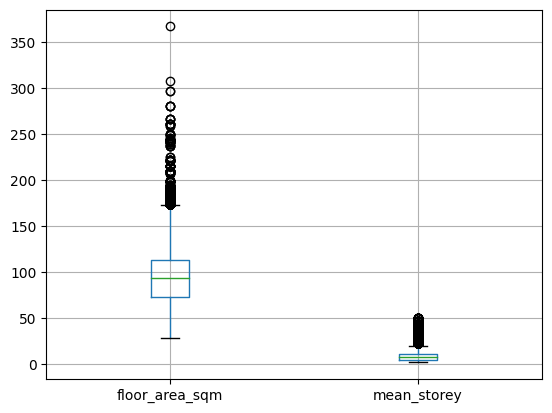

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

data_to_plot1 = df[['floor_area_sqm','mean_storey']]
#data_to_plot2 = df['resale_price']
data_to_plot1.boxplot()
#plt.show()
#sns.boxplot(y=df['resale_price'])
plt.show()

### Data pre-processing Step 5: Fix Outliers

Fixed Outliers


|       |   floor_area_sqm |   lease_commence_date |   resale_price |   mean_storey |        year |
|:------|-----------------:|----------------------:|---------------:|--------------:|------------:|
| count |      932742      |           932742      | 932742         |  932742       | 932742      |
| mean  |          95.5282 |             1988.36   | 323277         |       7.45193 |  20069.7    |
| std   |          25.4222 |               10.7398 | 172687         |       4.18732 |     94.1664 |
| min   |          28      |             1966      |   5000         |       2       |  19901      |
| 25%   |          73      |             1981      | 195000         |       5       |  19992      |
| 50%   |          93      |             1986      | 300000         |       8       |  20056      |
| 75%   |         113      |             1996      | 420000         |      11       |  20147      |
| max   |         173      |             2020      |      1.588e+06 |      20      

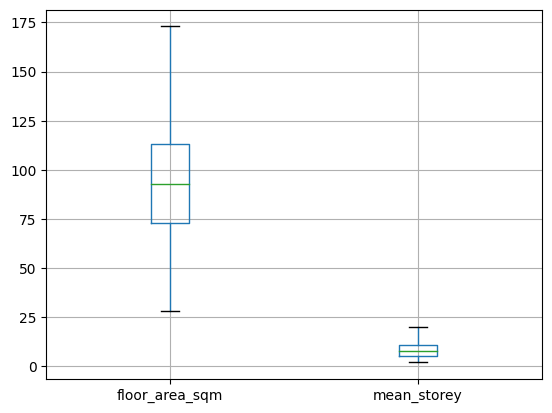

In [ ]:
def fix_outliers(dfo, cols, high_quantile=0.75,low_quantile=0.25):
  #cols=list(dfo.columns)
  for col in cols:
    q1= dfo[col].quantile(low_quantile)
    q3= dfo[col].quantile(high_quantile)
    iqr=q3-q1
    high=q3+iqr*1.5
    low=q1-iqr*1.5
    dfo[col]=dfo[col].apply(lambda x: dfo[col].quantile(high_quantile) if x>high else dfo[col].quantile(low_quantile) if x<low else x)
  return dfo

cols_out = list(data_to_plot1.columns)
df = fix_outliers(df, cols_out)
print('Fixed Outliers')
print("\n")

print(df.describe().to_markdown())
print("\n")
print('Box plot with Fixed Outliers')
data_to_plot2 = df[['floor_area_sqm','mean_storey']]
data_to_plot2.boxplot()
plt.show()

### Encoding Categorical Values
- 'flat_type' & 'flat_model': use one_hot encoding
- 'locality': use label encoder

In [ ]:
df = pd.get_dummies(df,columns=['flat_type','flat_model'], drop_first=True, dtype=int)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['location'] = le.fit_transform(df['location'].values)
print(df.sample(5).to_markdown())

|        |   floor_area_sqm |   lease_commence_date |   resale_price |   location |   mean_storey |   year |   flat_type_2 ROOM |   flat_type_3 ROOM |   flat_type_4 ROOM |   flat_type_5 ROOM |   flat_type_EXECUTIVE |   flat_type_MULTI GENERATION |   flat_type_MULTI-GENERATION |   flat_model_2-room |   flat_model_3Gen |   flat_model_APARTMENT |   flat_model_Adjoined flat |   flat_model_Apartment |   flat_model_DBSS |   flat_model_IMPROVED |   flat_model_IMPROVED-MAISONETTE |   flat_model_Improved |   flat_model_Improved-Maisonette |   flat_model_MAISONETTE |   flat_model_MODEL A |   flat_model_MODEL A-MAISONETTE |   flat_model_MULTI GENERATION |   flat_model_Maisonette |   flat_model_Model A |   flat_model_Model A-Maisonette |   flat_model_Model A2 |   flat_model_Multi Generation |   flat_model_NEW GENERATION |   flat_model_New Generation |   flat_model_PREMIUM APARTMENT |   flat_model_Premium Apartment |   flat_model_Premium Apartment Loft |   flat_model_Premium Maisonette |   flat_mod

### Training: Develop Linear Regression Model with the preprocessed dataset

In [ ]:
import pandas as pd, numpy as np

# Seperate the features from target(s)
X=df.drop(columns=['resale_price'])
y=df['resale_price'].values

# Split the X and y values into train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Select an alogorithm to train the model - LinearRegression()
from sklearn.linear_model import LinearRegression
model = LinearRegression()

#Train the Linear Regression model on the train dataset
regressor=model.fit(X_train,y_train)

# Compare the scores on train and test datasets
print(f'''\nTrain Score {model.score(X_train,y_train)}''')
print(f'''Test Score {model.score(X_test,y_test)}''')

# List the model co-efficients for all the features
print(f'Coefs:{model.coef_}')

# Print the intercept
print(f'Intercept:{model.intercept_}')

from sklearn.metrics import mean_squared_error as mae
print(f'Mean Squared Error: {mae(y_test, model.predict(X_test))}')

#import pickle
#pickle.dump(regressor, open('LinearModel_SingHouse-v1.pkl','wb'))


Train Score 0.7953295799490008
Test Score 0.7956382845901867
Coefs:[ 1.38134324e+03  1.73290948e+03 -3.97575698e+00  3.42632024e+03
  1.37210765e+03 -1.99006744e+04  3.98314741e+04  9.09619653e+04
  1.35474898e+05  1.65321389e+05  9.48286798e+04  7.43445452e+04
 -1.91985014e+05 -6.64046471e+04  4.61150492e+03 -6.58255948e+04
 -1.03612814e+05  8.47651884e+04 -4.50799265e+04 -4.22090502e+04
 -1.33012009e+05 -4.03411554e+04 -1.85640238e+03 -4.99364162e+04
 -2.84406906e+04  9.48286798e+04 -7.18998731e+04 -1.36820285e+05
 -4.06833160e+04 -1.87540923e+05  7.43445452e+04 -6.41178251e+04
 -1.38317962e+05  2.03590486e+05 -1.48876852e+05  2.39576380e+05
  6.98135458e+03 -7.12571655e+04 -3.46351063e+04 -1.55527220e+05
 -9.31776324e+04  1.46016049e+05  2.38457590e+05  3.06066479e+05
  3.61519019e+05]
Intercept:-30782169.436805442
Mean Squared Error: 6074821962.104229


###REDO LinearREg

In [ ]:
#REDO the linear regression with scaled inputs

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
X_train_mmscaled = scaler.fit_transform(X_train)
X_test_mmscaled = scaler.fit_transform(X_test)

#Train the Linear Regression model on the train dataset
regressor=model.fit(X_train_mmscaled,y_train)

# Compare the scores on train and test datasets
print(f'''\nTrain Score {model.score(X_train_mmscaled,y_train)}''')
#print(f'''Test Score {model.score(X_test,y_test)}''')

# List the model co-efficients for all the features
print(f'Coefs:{model.coef_}')

# Print the intercept
print(f'Intercept:{model.intercept_}')

from sklearn.metrics import mean_squared_error as mae
#print(f'Mean Squared Error: {mae(y_test, model.predict(X_test))}')

#import pickle
#pickle.dump(regressor, open('LinearModel_SingHouse-v1.pkl','wb'))


Train Score 0.7953295799490008
Coefs:[ 200294.76946553   93577.11208414  -36421.90964911   61673.76425032
  476121.35617475  -19900.67440599   39831.47409538   90961.96525685
  135474.89777676  165321.38882961   94828.67977914   74344.54520209
 -191985.01411495  -66404.647129      4611.50492201  -65825.59476094
 -103612.81396398   84765.18842458  -45079.92654523  -42209.05019622
 -133012.00876647  -40341.15543647   -1856.40237999  -49936.41618037
  -28440.69058194   94828.67977914  -71899.87309831 -136820.28479256
  -40683.31598893 -187540.92342848   74344.54520209  -64117.82511926
 -138317.96172183  203590.4862015  -148876.85239562  239576.37957672
    6981.35457914  -71257.16553049  -34635.10628074 -155527.21960682
  -93177.63244205  146016.04910883  238457.58972445  306066.47934562
  361519.01853411]
Intercept:-23424.706190081895


###   Now, the objective is to explore options *to* improve the Score from 80% prediction accuracy to much higher.

Ensemble Learning -- Try Random Forest Regressor


In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the test data
predictions = regressor.predict(X_test)

# Evaluating the model
#mse = mean_squared_error(y_test, predictions)
#print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

import pickle
pickle.dump(regressor, open('RandomForest_SingHouse-v1.pkl','wb'))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Out-of-Bag Score: 0.9296525992686613
Mean Squared Error: 669509972.0087175
R-squared: 0.9774771660441741


### Let's try Scaling the data and re-apply RF Regressor

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
X_train_mmscaled = scaler.fit_transform(X_train)
X_test_mmscaled = scaler.transform(X_test)

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train_mmscaled, y_train)

# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the test data
predictions = regressor.predict(X_test_mmscaled)

# Evaluating the model
#mse = mean_squared_error(y_test, predictions)
#print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

#import pickle
#pickle.dump(regressor, open('RandomForest_SingHouse-v1.pkl','wb'))

(array([[0.12413793, 0.12962963, 0.20588235, ..., 0.        , 0.        ,
         0.        ],
        [0.3862069 , 0.40740741, 0.47058824, ..., 0.        , 0.        ,
         0.        ],
        [0.57931034, 0.90740741, 0.82352941, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.52413793, 0.48148148, 0.17647059, ..., 0.        , 0.        ,
         0.        ],
        [0.25517241, 0.16666667, 0.41176471, ..., 0.        , 0.        ,
         0.        ],
        [0.44137931, 0.2037037 , 0.29411765, ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.31034483, 0.18518519, 0.29411765, ..., 0.        , 0.        ,
         0.        ],
        [0.27586207, 0.25925926, 0.88235294, ..., 0.        , 0.        ,
         0.        ],
        [0.54482759, 0.55555556, 0.29411765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.31034483, 0.40740741, 0.35294118, ..., 0.        , 0.        ,
         0.        ],
        [0.2


RF Regressor gives 98% accuracy independent of MinMax scaling

RF Regressor seems to be better model Vs. Linear Regression

Let's explore if PCA Analysis can yield an even more robust and accuracte model as it uses components (extracted out of features) to run the model.

### PCA Analysis

*   Use input features to generate Components(extracted from combination of features)
*   Evaluate Expl. Variance Ratio to determine how many components are required to get high accuracy
*   Will use 1 component, which itself results in 99% accuracy





In [ ]:
from sklearn.decomposition import PCA
# Seperate the features from target(s)
X=dftry.drop(columns=['resale_price']).values
y=dftry['resale_price'].values

# Split the X and y values into train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

pca = PCA()
pca.fit(X_train)
evr = np.cumsum(pca.explained_variance_ratio_*100)
print(evr)

#df_pca= pd.DataFrame(pca.fit_transform(dftry.drop(columns=['resale_price'])), columns=[f'C{x}' for x in range(1,dftry.drop(columns=['resale_price']).shape[1]+1)])
n_pc=1
pca2=PCA(n_components=n_pc)
df_pca2 = pd.DataFrame(pca2.fit_transform(dftry), columns=[f'C{x}' for x in range(1,n_pc+1)])
df_pca2.head(5)



[ 99.87621398  99.9904142   99.99879509  99.99976376  99.9999836
  99.99998843  99.99999085  99.99999258  99.99999389  99.99999497
  99.9999959   99.99999673  99.99999731  99.99999781  99.99999825
  99.99999857  99.99999886  99.99999913  99.99999933  99.99999951
  99.99999965  99.99999978  99.99999984  99.99999989  99.99999991
  99.99999993  99.99999994  99.99999995  99.99999996  99.99999997
  99.99999998  99.99999998  99.99999999  99.99999999  99.99999999
  99.99999999 100.         100.         100.         100.
 100.         100.         100.         100.         100.        ]


,C1
0,-314280.705603
1,-317280.704504
2,-315280.705228
3,-317280.704491
4,-276080.750790


In [ ]:
import pandas as pd, numpy as np

# Seperate the features from target(s)
X=df_pca2['C1'].values.reshape(-1,1)  # always expects a 2D array
y=dftry['resale_price'].values.reshape(-1,1)
# Split the X and y values into train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Select an alogorithm to train the model - here LinearRegression()
from sklearn.linear_model import LinearRegression
model = LinearRegression()

#Train the Linear Regression model on the train dataset
model.fit(X_train,y_train)

# Compare the scores on train and test datasets
print(f'''\nTrain Score {model.score(X_train,y_train)}''')
print(f'''Test Score {model.score(X_test,y_test)}''')

# List the model co-efficients for all the features
print(f'Coefs:{model.coef_}')

# Print the intercept
print(f'Intercept:{model.intercept_}')



Train Score 0.9999999998430774
Test Score 0.9999999998425069
Coefs:[[0.99999962]]
Intercept:[323277.45319701]


### Test for correlation between features for possible Feature reduction

In [ ]:
def get_best_corr(corr, abs_bound=0.5, n=0):
  np.fill_diagonal(corr.values, np.nan)
  mask = np.triu(np.ones_like(corr, dtype=bool))
  mask_corr = corr.where(mask).stack().reset_index()
  filtered_corr = mask_corr[(mask_corr[0] <= abs_bound) & (mask_corr[0] >= -abs_bound)]
  filtered_corr.columns = ['Row ID', 'Column ID', 'Uncorrelation']
  sort_corr = filtered_corr.sort_values(by='Uncorrelation', ascending=False)
  print("\n")
  print(sort_corr.to_markdown())
  print("\n")

  return sort_corr
corr = df.corr()
sorted_corr_pairs = get_best_corr(corr, n=5)
kot = corr[(corr<=.4)]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Greens")



|      | Row ID                            | Column ID                         |   Uncorrelation |
|-----:|:----------------------------------|:----------------------------------|----------------:|
|  380 | flat_type_5 ROOM                  | flat_model_Improved               |     0.498014    |
|  421 | flat_type_EXECUTIVE               | flat_model_Maisonette             |     0.48689     |
|   48 | lease_commence_date               | year                              |     0.434262    |
|  417 | flat_type_EXECUTIVE               | flat_model_MAISONETTE             |     0.403783    |
|  351 | flat_type_4 ROOM                  | flat_model_Model A                |     0.400407    |
|    0 | floor_area_sqm                    | lease_commence_date               |     0.382941    |
|  409 | flat_type_EXECUTIVE               | flat_model_APARTMENT              |     0.363116    |
|   71 | lease_commence_date               | flat_model_Model A                |     0.360193    |
|   78 |

In [ ]:
df_validate=pd.DataFrame({'Actual':y_test, 'Predicted':predictions})
df_validate['Deviation_percentage'] = (1-(df_validate['Actual']-df_validate['Predicted'])/ df_validate['Actual'])*100
df_validate['Deviation_percentage'].head(10)

,Accuracy_percentage
0,109.104077
1,94.305556
2,105.802239
3,97.389937
4,110.304487
...,...
95,78.652643
96,94.708995
97,86.678571
98,89.432432


In [ ]:
df_validate.describe(percentiles=[.05, .5, .75, .90, .95, .99])
# good prediction accuracy between 5-99 percentile. curve is spread too thin at both ends/sides.

,Actual,Predicted,Accuracy_percentage
count,186549.0,1.865490e+05,186549.0
mean,322574.984442,3.225654e+05,100.760044
std,172412.270636,1.709614e+05,10.410557
min,5000.0,7.246667e+03,33.272727
5%,90000.0,9.130000e+04,87.014901
50%,298000.0,2.983000e+05,100.171569
75%,420000.0,4.192000e+05,104.723558
90%,548000.0,5.458000e+05,110.37037
95%,642852.8,6.403592e+05,115.529547
99%,854461.76,8.449520e+05,134.211273


In [ ]:
'''
import pickle

# open a file, where you stored the pickled data
file = open('important', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()


model = pickle.load(open('model.pkl','rb'))
'''